In [14]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
from tensorflow.python.client import device_lib

In [16]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13293409002760829279
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2125353023104283223
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8649270244006109043
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4581163008
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16501562773583089862
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [17]:
from performance_evaluation import plot_training_history, evaluate_model_performance

#### Read in Data
 - normalize between 0 and 1

In [18]:
train_x = pd.read_pickle('data/train_x_order_only.pkl').values
train_y = pd.read_pickle('data/train_y_order_only.pkl').values

In [19]:
test_x = pd.read_pickle('data/test_x_order_only.pkl').values
test_y = pd.read_pickle('data/test_y_order_only.pkl').values

In [20]:
train_x.shape

(135889, 759)

In [21]:
train_y.shape

(135889, 6)

# Random Numbers

In [22]:
pred_y = np.random.uniform(0,1,test_y.shape)

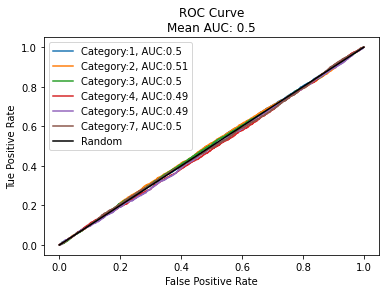

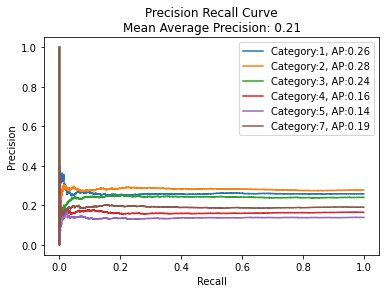

In [23]:
evaluate_model_performance(pred_y, test_y)

# Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

## Select Important Features

In [25]:
# Create Random Variables
random_vars = np.random.uniform(0,1,(135889,3))
train_x_random = np.hstack((train_x, random_vars))

In [26]:
# Train Model
RF_Model = RandomForestClassifier(n_jobs=-1, max_depth=10)
RF_Model.fit(train_x_random, train_y)

RandomForestClassifier(max_depth=10, n_jobs=-1)

In [27]:
from performance_evaluation import model_vars

In [28]:
model_vars_random = np.array(model_vars+['rand1', 'rand2', 'rand3'])

In [29]:
variable_importance = pd.DataFrame(
    [RF_Model.feature_importances_], columns=model_vars_random
)

#### Grab Variables with importance > Max of the 3 random variables

In [30]:
average_random_importance = variable_importance[['rand1', 'rand2', 'rand3']].T.max()[0]

In [31]:
significant_var_mask = np.argwhere(RF_Model.feature_importances_ > average_random_importance)

In [32]:
sig_var_names = model_vars_random[significant_var_mask][:,0]
sig_var_importance = RF_Model.feature_importances_[significant_var_mask][:,0]
sig_var_df = pd.DataFrame([sig_var_importance], columns = sig_var_names)
sig_var_df = sig_var_df.T.sort_values(0,ascending=False)

In [33]:
plt.rcParams["figure.figsize"] = (5,10)

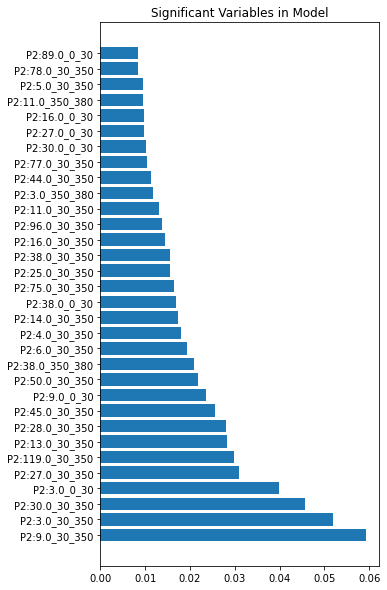

In [34]:
plt.barh(sig_var_df.index, sig_var_df[0])
plt.title('Significant Variables in Model')
plt.show()

## Train Model on Significant Features

In [35]:
sig_train_x = train_x[:,significant_var_mask[:,0]]

In [36]:
# Train Model
RF_Model = RandomForestClassifier(n_jobs=-1, max_depth=20)
RF_Model.fit(sig_train_x, train_y)

RandomForestClassifier(max_depth=20, n_jobs=-1)

In [37]:
sig_test_x = test_x[:,significant_var_mask[:,0]]

In [38]:
train_pred_y = np.array(RF_Model.predict_proba(sig_train_x))
train_pred_y = train_pred_y[:,:,1].T

In [39]:
plt.rcParams["figure.figsize"] = (5,5)

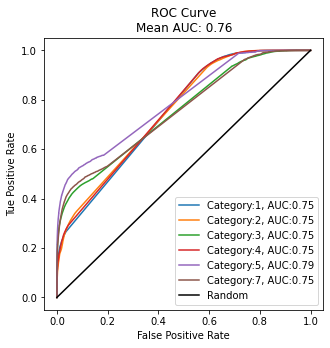

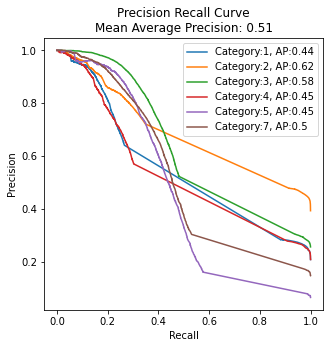

In [40]:
evaluate_model_performance(train_pred_y, train_y)

In [41]:
test_pred_y = np.array(RF_Model.predict_proba(sig_test_x))
test_pred_y = test_pred_y[:,:,1].T

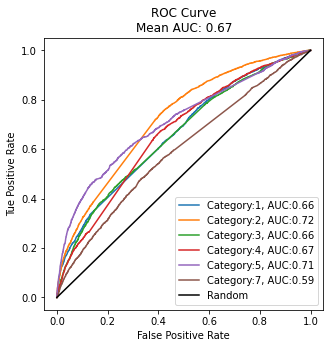

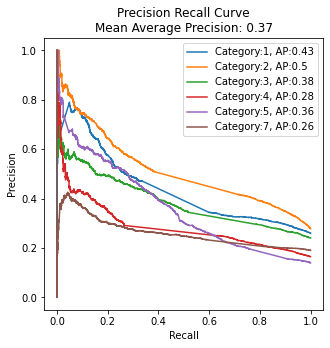

In [42]:
evaluate_model_performance(test_pred_y, test_y)

# Deep Fully Connected NN

#### Normalize for Faster Training

In [ ]:
def zero_to_ones(value):
    if value ==0:
        return 1
    else:
        return value

range_for_x_cols = np.amax(train_x, axis=0) - np.amin(train_x, axis=0)
range_for_x_cols = np.array([zero_to_ones(x) for x in range_for_x_cols])

norm_train_x = train_x/range_for_x_cols
norm_test_x = test_x/range_for_x_cols

# Build Model

In [ ]:
def fully_connected_network(
    X, layrs, activation, last_activation, dropout, regularizer
):
    input_layer = x = keras.Input(shape=(X.shape[1],), name='Order_History')
    
    i = 0
    for layer in layrs:
        i+=1
        x = layers.BatchNormalization(name=f'BatchNorm{i}')(x)
        x = layers.Dense(layer, activation=activation, name=f'Dense{i}')(x)
        x = layers.Dropout(dropout, name=f'Dropout{i}')(x)
    
    outputs = layers.Dense(6, activation=last_activation)(x)
    
    model = keras.Model(inputs=input_layer, outputs=outputs, name="Fully_Connected_Model")
    return model

In [ ]:
fc_layers = [800, 400, 400, 200, 200, 100, 50, 10]

In [ ]:
model = fully_connected_network(norm_train_x, fc_layers, 'elu', 'sigmoid', .8, 1)

In [ ]:
model.summary()

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(norm_train_x, train_y, batch_size=1000, epochs=20000, validation_split=0.2)

In [ ]:
plot_training_history(history)

#### Training Performance

In [ ]:
pred_y = model.predict(norm_train_x)
evaluate_model_performance(pred_y, train_y)

#### Test Performance

In [ ]:
pred_y = model.predict(norm_test_x)
evaluate_model_performance(pred_y, test_y)